In [1]:
import time
import pickle

import scipy
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

import torch
import torch.nn as nn

import deepinv

from pnp_unrolling.unrolled_cdl import UnrolledCDL
from utils.measurement_tools import get_operators
from utils.tools import op_norm2
from pnp_unrolling.datasets import (
    create_imagenet_dataloader,
)


def plot_img(img, ax, title=None):
    img = img.detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1)
    ax.imshow(img)
    ax.set_axis_off()
    if title:
        ax.set_title(title)


DATASET = "bsd"
COLOR = True
DEVICE = "cuda:0" #"cuda:3"
STD_NOISE = 0.05

# Here the dataset is "BSD" but we use the same create_imagenet_dataloader
# function which need to set dataset="imagenet"
create_dataloader = create_imagenet_dataloader
DATA_PATH = "./BSDS500/BSDS500/data/images"
DATASET = "imagenet"

/users/eleves-b/2021/jeremie.touati/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.5.1 available.


### Training the denoisers

In [2]:
params_model_1l_50c = {
    "n_layers": 1,
    "n_components": 50,
    "kernel_size": 5,
    "lmbd": 1e-4,
    "color": COLOR,
    "device": DEVICE,
    "dtype": torch.float,
    "optimizer": "adam",
    "path_data": DATA_PATH,
    "max_sigma_noise": STD_NOISE,
    "min_sigma_noise": STD_NOISE,
    "mini_batch_size": 1,
    "max_batch": 10,
    "epochs": 50,
    "avg": False,
    "rescale": False,
    "fixed_noise": True,
    "D_shared": True,
    "step_size_scaling": 1.8,
    "lr": 1e-3,
    "dataset": DATASET,
}
params_model_20l_50c = {k: v for k, v in params_model_1l_50c.items()}
params_model_20l_50c["n_layers"] = 20

params_model_1l_10c = {k: v for k, v in params_model_1l_50c.items()}
params_model_1l_10c["n_components"] = 10

params_model_20l_10c = {k: v for k, v in params_model_1l_10c.items()}
params_model_20l_10c["n_layers"] = 20

params_model_1l_100c = {k: v for k, v in params_model_1l_50c.items()}
params_model_1l_100c["n_components"] = 100
params_model_20l_100c = {k: v for k, v in params_model_1l_100c.items()}
params_model_20l_100c["n_layers"] = 20


def get_denoiser(model, **kwargs):

    if model == "drunet":
        nc = 3 if COLOR else 1
        net = deepinv.models.DRUNet(
            in_channels=nc,
            out_channels=nc,
            nc=[64, 128, 256, 512],
            nb=4,
            act_mode="R",
            downsample_mode="strideconv",
            upsample_mode="convtranspose",
            pretrained="download",
        )
        net = nn.DataParallel(net, device_ids=[int(DEVICE[-1])])
    elif model in ["analysis", "synthesis"]:
        unrolled_cdl = UnrolledCDL(type_unrolling=model, **kwargs)
        # Training unrolled networks
        net, *_ = unrolled_cdl.fit()
    else:
        raise ValueError(
            f"Requested denoiser {model} which is not available."
        )
    return net


DENOISERS = {
    'SD_20L_100C': dict(model="synthesis", **params_model_20l_100c),
    'AD_20L_100C': dict(model="analysis", **params_model_20l_100c),
    'SD_20L_50C': dict(model="synthesis", **params_model_20l_50c),
    'AD_20L_50C': dict(model="analysis", **params_model_20l_50c),
    'SD_20L_10C': dict(model="synthesis", **params_model_20l_10c),
    'AD_20L_10C': dict(model="analysis", **params_model_20l_10c),
    'SD_1L_100C': dict(model="synthesis", **params_model_1l_100c),
    'AD_1L_100C': dict(model="analysis", **params_model_1l_100c),
    'SD_1L_50C': dict(model="synthesis", **params_model_1l_50c),
    'AD_1L_50C': dict(model="analysis", **params_model_1l_50c),
    'SD_1L_10C': dict(model="synthesis", **params_model_1l_10c),
    'AD_1L_10C': dict(model="analysis", **params_model_1l_10c),
    "DRUNet": dict(model="drunet"),
}

for n in DENOISERS:
    print(f"Loading {n}")
    DENOISERS[n]["net"] = get_denoiser(**DENOISERS[n])

Loading SD_20L_100C


Epoch 50 - Average train loss: 0.00240253 - Average test loss: 0.00237077: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Done
Loading AD_20L_100C


Epoch 50 - Average train loss: 0.00231134 - Average test loss: 0.00229949: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


Done
Loading SD_20L_50C


Epoch 50 - Average train loss: 0.00238669 - Average test loss: 0.00235482: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


Done
Loading AD_20L_50C


Epoch 50 - Average train loss: 0.00230759 - Average test loss: 0.00234145: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Done
Loading SD_20L_10C


Epoch 50 - Average train loss: 0.00237981 - Average test loss: 0.00238754: 100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


Done
Loading AD_20L_10C


Epoch 50 - Average train loss: 0.00238565 - Average test loss: 0.00238855: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Done
Loading SD_1L_100C


Epoch 50 - Average train loss: 0.05259554 - Average test loss: 0.04409669: 100%|██████████| 50/50 [00:03<00:00, 14.19it/s]


Done
Loading AD_1L_100C


Epoch 50 - Average train loss: 0.00232884 - Average test loss: 0.00231333: 100%|██████████| 50/50 [00:03<00:00, 13.01it/s]


Done
Loading SD_1L_50C


Epoch 50 - Average train loss: 0.04161137 - Average test loss: 0.04772115: 100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Done
Loading AD_1L_50C


Epoch 50 - Average train loss: 0.00241262 - Average test loss: 0.00234203: 100%|██████████| 50/50 [00:03<00:00, 14.63it/s]


Done
Loading SD_1L_10C


Epoch 50 - Average train loss: 0.05905652 - Average test loss: 0.04381371: 100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


Done
Loading AD_1L_10C


Epoch 50 - Average train loss: 0.00243588 - Average test loss: 0.00240384: 100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


Done
Loading DRUNet


In [3]:
DENOISERS.keys()

dict_keys(['SD_20L_100C', 'AD_20L_100C', 'SD_20L_50C', 'AD_20L_50C', 'SD_20L_10C', 'AD_20L_10C', 'SD_1L_100C', 'AD_1L_100C', 'SD_1L_50C', 'AD_1L_50C', 'SD_1L_10C', 'AD_1L_10C', 'DRUNet'])

In [4]:
# Add a denoiser composed of multiple iteration of a denoiser trained
# with one layer
for n in ["SD_1L_100C", "AD_1L_100C", "SD_1L_50C", "AD_1L_50C", "SD_1L_10C", "AD_1L_10C"]:
    denoiser = DENOISERS[n]
    for n_rep in [20]:#, 50]:
        if n_rep == 50 and n == "AD":
            continue
        old_net = denoiser["net"]
        net = UnrolledCDL(
            type_unrolling=denoiser["model"],
            **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
        ).unrolled_net
        assert len(net.model) == 1
        net.parameter = old_net.parameter
        net.model = torch.nn.ModuleList([old_net.model[0]] * n_rep)
        DENOISERS[f"{n}_repeat_{n_rep}"] = dict(
            net=net, model=denoiser["model"]
        )

# Restrict the model trained with 20 layers to only one layer
for n in ["SD_20L_100C", "AD_20L_100C", "SD_20L_50C", "AD_20L_50C", "SD_20L_10C", "AD_20L_10C"]:
    denoiser = DENOISERS[n]
    old_net = denoiser["net"]
    net = UnrolledCDL(
        type_unrolling=denoiser["model"],
        **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
    ).unrolled_net
    assert len(net.model) == 20
    # Replace the model with only the first layer of the trained model
    net.parameter = old_net.parameter
    net.model = torch.nn.ModuleList([old_net.model[0]])
    DENOISERS[f"{n}_only1"] = dict(net=net, model=denoiser["model"])
print("All denoisers loaded")

All denoisers loaded


In [7]:
len(DENOISERS.keys())

25

### Visualizing the denoising operator/dictionary

Evaluating all denoisers...


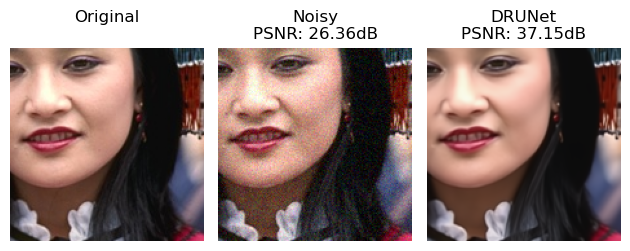

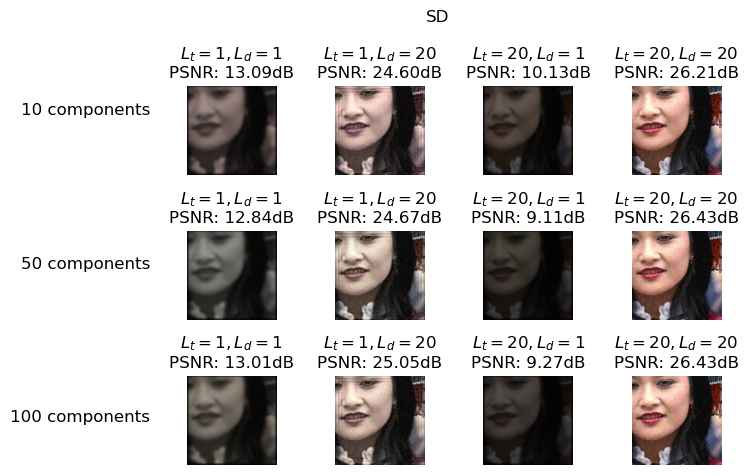

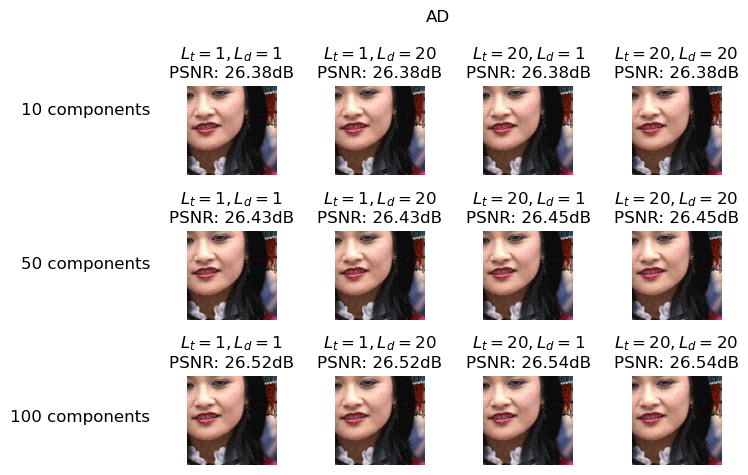

In [144]:
print("Evaluating all denoisers...")
dataloader = create_dataloader(
    DATA_PATH, STD_NOISE, STD_NOISE, device=DEVICE, dtype=torch.float,
    mini_batch_size=1, train=True, random_state=42, color=COLOR,
    download=True, fixed_noise=True
)
img_noise, img = next(iter(dataloader))

n_d = len(DENOISERS)
fig, axes = plt.subplots(1, 3)
axes = axes.flatten()

plot_img(img[0], axes[0], title="Original\n")
psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), img_noise[0].detach().cpu().numpy())
plot_img(img_noise[0], axes[1], title=f"Noisy\nPSNR: {psnr:.2f}dB")
denoise_img = DENOISERS["DRUNet"]["net"](img_noise, STD_NOISE)[0]
psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
plot_img(denoise_img, axes[2], title=f"DRUNet\nPSNR: {psnr:.2f}dB")
plt.tight_layout()
plt.show()

for denoiser_type in ["SD", "AD"]:
    fig, axes = plt.subplots(3, 4)
    axes = axes.flatten()
    i = 0
    for components in [10, 50, 100]:
        name = f"{denoiser_type}_1L_{components}C"
        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
        psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
        plot_img(denoise_img, axes[i], title=rf"$L_t=1, L_d=1$"+f"\nPSNR: {psnr:.2f}dB")
        i += 1
        
        name = f"{denoiser_type}_1L_{components}C_repeat_20"
        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
        psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
        plot_img(denoise_img, axes[i], title=rf"$L_t=1, L_d=20$"+f"\nPSNR: {psnr:.2f}dB")
        i += 1
        
        name = f"{denoiser_type}_20L_{components}C_only1"
        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
        psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
        plot_img(denoise_img, axes[i], title=rf"$L_t=20, L_d=1$"+f"\nPSNR: {psnr:.2f}dB")
        i += 1
        
        name = f"{denoiser_type}_20L_{components}C"
        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
        psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
        plot_img(denoise_img, axes[i], title=rf"$L_t=20, L_d=20$"+f"\nPSNR: {psnr:.2f}dB")
        i += 1
    
    row_labels = [f"{components} components" for components in [10, 50, 100]]
    for i, label in enumerate(row_labels):
        fig.text(0.05, 0.77 - i * 0.32, label, va='center', ha='right', fontsize=12)
    fig.suptitle(denoiser_type)
    plt.tight_layout(rect=[0.05, 0, 1, 1])
    plt.show()

In [129]:
n_imgs = 100
denoising_results = []
for k, (img_noise, img) in enumerate(dataloader):
    if k == n_imgs:
        print("\rDone computing runtime")
        break
    print(f"\rImage {k}/{n_imgs}", end="")
       
    for denoiser_type in ["SD", "AD"]:
        for components in [10, 50, 100]:
            for name in [f"{denoiser_type}_1L_{components}C", f"{denoiser_type}_1L_{components}C_repeat_20", f"{denoiser_type}_20L_{components}C_only1", f"{denoiser_type}_20L_{components}C", "DRUNet"]:
                with torch.no_grad():
                    t_start = time.perf_counter()
                    if name == "DRUNet":
                        denoise_img = DENOISERS[name]["net"](img_noise, STD_NOISE)[0]
                    else:
                        denoise_img = DENOISERS[name]["net"](img_noise)[0][0]
                    t_end = time.perf_counter()
                    psnr = peak_signal_noise_ratio(img[0].detach().cpu().numpy(), denoise_img.detach().cpu().numpy())
                    denoising_results.append({
                        'id_img': k,
                        'denoiser': name,
                        'runtime': t_end - t_start,
                        'psnr': psnr
                    })

results = pd.DataFrame(denoising_results)

Done computing runtime


In [143]:
mean_per_denoiser = results.groupby('denoiser')["psnr"].agg("mean").to_dict()
std_per_denoiser = results.groupby('denoiser')["psnr"].agg("std").to_dict()

latex_table = r"""
\begin{table}[H]
    \centering
    \begin{tabular}{|c|c|}
        \hline"""
name = "DRUNet"
mean = mean_per_denoiser[name]
std = std_per_denoiser[name]
latex_table += f" {name} & {mean:.2f} $\pm$ {std:.2f}"
latex_table += r"""" \\ \hline
    \end{tabular}
    \caption{Denoising performance (PSNR in dB) of DRUNet (on $100$ images of size $150 \times 150$).}
\end{table}
"""
print(latex_table)

for denoiser_type in ["SD", "AD"]:

    latex_table = r"""
\begin{table}[H]
    \renewcommand{\arraystretch}{1.5}
    \centering
    \begin{tabular}{|c|cc|cc|}
        \hline
        \multirow{2}{*}{\centering\# conv atoms} & \multicolumn{2}{c|}{$L_{train}=1$} & \multicolumn{2}{c|}{$L_{train}=20$} \\
        & $L_{den}=1$ & $L_{den}=20$ & $L_{den}=1$ & $L_{den}=20$ \\ \hline
    """

    for components in [10, 50, 100]:
        latex_table += f"{components}"
        for name in [f"{denoiser_type}_1L_{components}C", f"{denoiser_type}_1L_{components}C_repeat_20", f"{denoiser_type}_20L_{components}C_only1", f"{denoiser_type}_20L_{components}C"]:
            mean = mean_per_denoiser[name]
            std = std_per_denoiser[name]
            latex_table += f" & {mean:.2f} $\pm$ {std:.2f}"
        latex_table += r" \\ \hline" + "\n"

    latex_table += r"""
    \end{tabular}
    \caption{Denoising performance (PSNR in dB) of the""" + f" {denoiser_type} " + r"""(on $100$ images of size $150 \times 150$).}
\end{table}
    """
    print(latex_table)



\begin{table}[H]
    \centering
    \begin{tabular}{|c|c|}
        \hline DRUNet & 35.25 $\pm$ 2.47" \\ \hline
    \end{tabular}
    \caption{Denoising performance (PSNR in dB) of DRUNet (on $100$ images of size $150 \times 150$).}
\end{table}


\begin{table}[H]
    \renewcommand{\arraystretch}{1.5}
    \centering
    \begin{tabular}{|c|cc|cc|}
        \hline
        \multirow{2}{*}{\centering\# conv atoms} & \multicolumn{2}{c|}{$L_{train}=1$} & \multicolumn{2}{c|}{$L_{train}=20$} \\
        & $L_{den}=1$ & $L_{den}=20$ & $L_{den}=1$ & $L_{den}=20$ \\ \hline
    10 & 13.28 $\pm$ 2.14 & 22.98 $\pm$ 2.36 & 10.80 $\pm$ 2.35 & 26.08 $\pm$ 0.21 \\ \hline
50 & 13.23 $\pm$ 2.14 & 24.20 $\pm$ 2.19 & 9.85 $\pm$ 2.38 & 26.25 $\pm$ 0.20 \\ \hline
100 & 13.30 $\pm$ 2.14 & 23.92 $\pm$ 2.34 & 9.98 $\pm$ 2.36 & 26.25 $\pm$ 0.20 \\ \hline

    \end{tabular}
    \caption{Denoising performance (PSNR in dB) of the SD (on $100$ images of size $150 \times 150$).}
\end{table}
    

\begin{table}[H]
    \re

In [149]:
mean_per_denoiser = results.groupby('denoiser')["runtime"].agg("mean").to_dict()
std_per_denoiser = results.groupby('denoiser')["runtime"].agg("std").to_dict()

latex_table = r"""
\begin{table}[H]
    \centering
    \begin{tabular}{|c|c|}
        \hline"""
name = "DRUNet"
mean = mean_per_denoiser[name]
std = std_per_denoiser[name]
latex_table += f" {name} & {1000*mean:.2f} $\pm$ {1000*std:.2f}"
latex_table += r"""" \\ \hline
    \end{tabular}
    \caption{Runtime ($\times 10^{-3}$ s) of DRUNet (on $100$ images of size $150 \times 150$).}
\end{table}
"""
print(latex_table)

for denoiser_type in ["SD", "AD"]:

    latex_table = r"""
\begin{table}[H]
    \renewcommand{\arraystretch}{1.5}
    \centering
    \begin{tabular}{|c|cc|cc|}
        \hline
        \multirow{2}{*}{\centering\# conv atoms} & \multicolumn{2}{c|}{$L_{train}=1$} & \multicolumn{2}{c|}{$L_{train}=20$} \\
        & $L_{den}=1$ & $L_{den}=20$ & $L_{den}=1$ & $L_{den}=20$ \\ \hline
    """

    for components in [10, 50, 100]:
        latex_table += f"{components}"
        for name in [f"{denoiser_type}_1L_{components}C", f"{denoiser_type}_1L_{components}C_repeat_20", f"{denoiser_type}_20L_{components}C_only1", f"{denoiser_type}_20L_{components}C"]:
            mean = mean_per_denoiser[name]
            std = std_per_denoiser[name]
            latex_table += f" & {1000*mean:.2f} $\pm$ {1000*std:.2f}"
        latex_table += r" \\ \hline" + "\n"

    latex_table += r"""
    \end{tabular}
    \caption{Runtime ($\times 10^{-3}$ s) of the""" + f" {denoiser_type} " + r"""(on $100$ images of size $150 \times 150$).}
\end{table}
    """
    print(latex_table)



\begin{table}[H]
    \centering
    \begin{tabular}{|c|c|}
        \hline DRUNet & 18.97 $\pm$ 0.17" \\ \hline
    \end{tabular}
    \caption{Runtime ($\times 10^{-3}$ s) of DRUNet (on $100$ images of size $150 \times 150$).}
\end{table}


\begin{table}[H]
    \renewcommand{\arraystretch}{1.5}
    \centering
    \begin{tabular}{|c|cc|cc|}
        \hline
        \multirow{2}{*}{\centering\# conv atoms} & \multicolumn{2}{c|}{$L_{train}=1$} & \multicolumn{2}{c|}{$L_{train}=20$} \\
        & $L_{den}=1$ & $L_{den}=20$ & $L_{den}=1$ & $L_{den}=20$ \\ \hline
    10 & 0.27 $\pm$ 0.08 & 2.75 $\pm$ 0.03 & 0.17 $\pm$ 0.02 & 2.70 $\pm$ 0.03 \\ \hline
50 & 0.21 $\pm$ 0.05 & 3.91 $\pm$ 0.13 & 0.20 $\pm$ 0.04 & 3.89 $\pm$ 0.13 \\ \hline
100 & 0.22 $\pm$ 0.06 & 5.64 $\pm$ 0.10 & 0.19 $\pm$ 0.04 & 5.63 $\pm$ 0.05 \\ \hline

    \end{tabular}
    \caption{Runtime ($\times 10^{-3}$ s) of the SD (on $100$ images of size $150 \times 150$).}
\end{table}
    

\begin{table}[H]
    \renewcommand{\arraystret